In [61]:
import numpy as np
import torch
import torchvision
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import nltk
import string

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Lab716A-PC\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [4]:
dataset = nltk.corpus.gutenberg

In [5]:
words = dataset.words()

In [6]:
len(words)

2621613

In [7]:
words[:10]

['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']', 'VOLUME', 'I', 'CHAPTER']

In [8]:
len(set(words))

51156

In [9]:
len(string.punctuation)

32

In [10]:
n_chars = len(dataset.raw())

In [11]:
n_chars

11793318

In [12]:
subset = dataset.raw()[: n_chars // 100]

In [18]:
char2idx = {}
idx2char = []

In [19]:
for c in dataset.raw():
    if c in char2idx:
        continue
    idx2char.append(c)
    char2idx[c] = len(idx2char) - 1

In [22]:
idx2char[:10]

['[', 'E', 'm', 'a', ' ', 'b', 'y', 'J', 'n', 'e']

In [17]:
dataset.raw()[:100]

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a'

In [266]:
train_split = 0.9
train_data = dataset.raw()[:int(0.7*len(dataset.raw()))]
valid_data = dataset.raw()[int(0.7*len(dataset.raw())):]
seq_len = 50
batch_size = 20
n_seq = len(train_data)//seq_len
X_train = np.zeros((n_seq*seq_len, len(idx2char)), dtype = np.short)
Y_train = np.zeros_like(X_train)
for i in range(n_seq*seq_len):
    c = train_data[i]
    X_train[i][char2idx[c]] = 1

for i in range(1, n_seq*seq_len + 1):
    c = train_data[i]
    Y_train[i - 1][char2idx[c]] = 1

In [267]:
X_train = X_train
X_train = X_train.reshape(-1, seq_len, len(idx2char))

In [268]:
X_train.shape

(165106, 50, 97)

In [269]:
Y_train = Y_train
Y_train = Y_train.reshape(-1, seq_len, len(idx2char))

In [270]:
Y_train.shape

(165106, 50, 97)

In [242]:
def get_batch(X_train, Y_train, batch_size):
    n = X_train.shape[0]
    idx = np.random.randint(0, n, batch_size)
    out = (X_train[idx], Y_train[idx])
    return out

In [271]:
data, labels = get_batch(X_train, Y_train, batch_size)

In [272]:
torch.argmax(torch.tensor(labels), dim = 2).shape

torch.Size([20, 50])

In [273]:
print(data.shape, labels.shape)

(20, 50, 97) (20, 50, 97)


In [262]:
class RNN(nn.Module):
    "Batch-first Elman RNN"
    def __init__(self, input_size, hidden_size, num_layers, non_linearity):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                          num_layers = num_layers, nonlinearity = non_linearity,
                          bias = True, batch_first=True, dropout=0, bidirectional=False)
        self.Who = nn.Linear(hidden_size, input_size)
    
    def forward(self, X, h=None):
        if h is not None:
            features, h = self.rnn(X, h)
        else:
            features, h = self.rnn(X)
        out = self.Who(features)
        return out, h
        

In [263]:
def sample(model, init_char, char2idx, idx2char, n_chars):
    x = np.zeros((1, 1, len(char2idx)), dtype = np.float)
    h = np.zeros((1, 1, hidden_dim), dtype = np.float)
    h = torch.tensor(h).to(device)
    x[0, 0, char2idx[init_char]] = 1
    x = torch.tensor(x).to(device)
    gen = [init_char]
    for i in range(n_chars):
        out, h = model(x.float(), h)
        probs = torch.softmax(out, dim = 2).detach().cpu().numpy()
        char = np.random.choice(idx2char, p = np.squeeze(probs))
        gen.append(char)
        x = np.zeros((1, 1, len(char2idx)), dtype = np.float)
        x[0, 0, char2idx[char]] = 1
        x = torch.tensor(x).to(device)
    return ''.join(gen)

In [274]:
input_size = len(idx2char)
hidden_dim = 128
num_layers = 1
model = RNN(input_size, hidden_dim, num_layers, 'tanh')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
loss_vals = []

In [275]:
n_epochs = 35
n_iters = len(X_train)//(seq_len*batch_size)
avg_loss = 0
for e in range(n_epochs):
    for i in range(n_iters):
        data, labels = get_batch(X_train, Y_train, batch_size)
        data = torch.tensor(data, dtype = torch.float).to(device)
        labels = torch.argmax(torch.tensor(labels), dim = 2)
        labels = labels.reshape((-1, ))
        
        optimizer.zero_grad()
        out, h = model(data)
        logits = out.cpu().reshape(-1, input_size)
        loss = criterion(logits, labels)
        
        loss.backward(retain_graph = True)
        optimizer.step()
        
        loss_vals.append(loss.item())
        avg_loss += loss_vals[-1]
    avg_loss /= n_iters
    print('Epoch = {}, avg loss = {:.3}'.format(e + 1, avg_loss))
    print(sample(model, 'a', char2idx, idx2char, 100))
    print('\n')

Epoch = 1, avg loss = 3.24
ac
 tiner rf  tesenal iro ih ttc es rurAo
nom  mre
wsr
rp  
diamnTi
anh t ph therrlifoeoiethbunp Jone


Epoch = 2, avg loss = 2.77
amy heuofy aiphal
thel ilseyRtr yur ra
the Tho  Aaua hadwy Iand mTeittiur he nhe hhure.  tay baEt ahy


Epoch = 3, avg loss = 2.42
akd gaputhe  iuce leemy bl; Got kean ond tator Tht cilgan ontof byme taag
me be irlpos bor tn shiwh T


Epoch = 4, avg loss = 2.29
aigscofesan bwtarered sole
seens hatlen f
peerllend hingthet flae pfored.

 Whou, the all her nigh


Epoch = 5, avg loss = 2.2
an and hed bllito; gof redel the and ye.  Be innono.

D8?r bive to wade . ar iond mo chilithee therre


Epoch = 6, avg loss = 2.16
ank fots av I wha houde vid an; in the Horenose hay "fry noud thele ve wha eflena d, and the An ald s


Epoch = 7, avg loss = 2.11
an tory the which,
ghay Jequald to Mare gitare.

25:24 And le terting
tlertslle thearast loune he was


Epoch = 8, avg loss = 2.08
awive:  he arnedlo
theke behere made claicen sece wis;
wishi

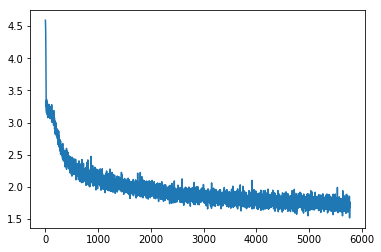

In [276]:
plt.plot(loss_vals)

In [277]:
print(sample(model, 'a', char2idx, idx2char, 500))

arns.

2:36 Then offustith your him not they whuch thou, and I have greed go
toover of had
the LORD what I son he msald
butted an one im
one of
the loon pophs the angling of amer, hoofy one hruskson, he hid with strongimare on the
had aby they soate reme, and pensioned ont they the macke inirsted, and townth our and rath Childreto; whit she thours; and aftery: 'bur he his reation of but seewa
from Bread, we acropte
to lethed the Lort her buber there he said nonem his wordh then, whe hrack of Isra
